In [1]:
from time import sleep
from os import chdir, mkdir
from os.path import isdir, isfile

try:
    chdir(r'A:\_Projetos\AnotacoesEstudosBackPythonLSP\Home\acoes')
except:
    chdir(r'C:\Users\GOMEE11\Documents\_Referencias\Git\AnotacoesEstudosBackPythonLSP\Home\acoes')

for d in ['.\\Graph', '.\\Tables']:
    if isdir(d):
        pass
    else:
        mkdir(d)
        pass

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from make_data import Down_Data, Analisys, Graph
import datetime

try:
    from selenium import webdriver
    selenium = True
    fundSite = 'http://www.fundamentus.com.br/detalhes.php?papel='
    xpath_price = '/html/body/div[1]/div[2]/table[1]/tbody/tr[1]/td[4]'
    xpath_lpa = '/html/body/div[1]/div[2]/table[3]/tbody/tr[2]/td[6]'
    xpath_vpa = '/html/body/div[1]/div[2]/table[3]/tbody/tr[3]/td[6]'
    xpath_numero_acoes = '/html/body/div[1]/div[2]/table[2]/tbody/tr[2]/td[4]'
    xpath_patrimonio_liquido = '/html/body/div[1]/div[2]/table[4]/tbody/tr[4]/td[4]'
    pass
except:
    pass

%matplotlib inline

# Analise individual de Ticker

### Analise Técnica

In [69]:
ticker = 'CTKA4'

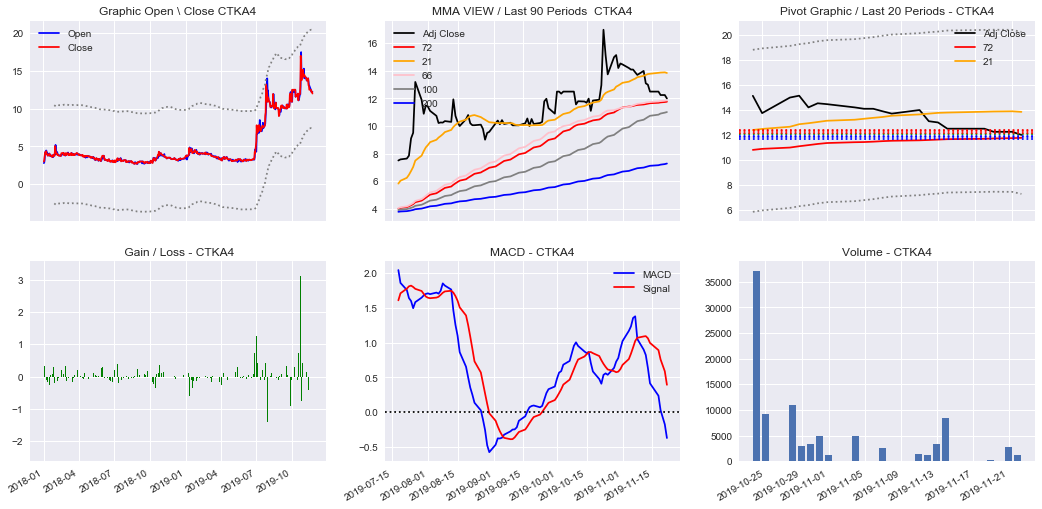

In [70]:
target = Down_Data(ticker)
analise = Analisys(target, ticker)
graph = Graph(target, ticker)

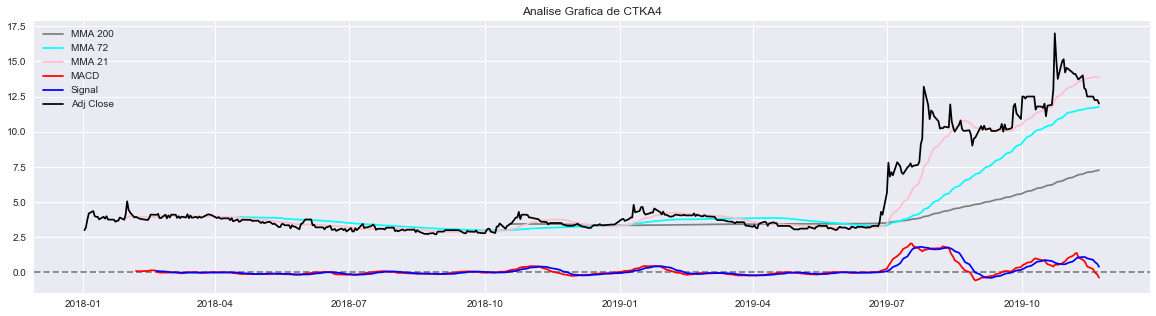

In [71]:
plt.figure(figsize=(20, 5))

plt.plot(analise['MMA200'], color='Grey', label='MMA 200')
plt.plot(analise['MMA72'], color='Cyan', label='MMA 72')
plt.plot(analise['MMA21'], color='Pink', label='MMA 21')

plt.axhline(0, color='Grey', linestyle="--")

plt.plot(analise['MACD'], color='Red', label='MACD')
plt.plot(analise['Signal'], color='Blue', label='Signal')

plt.plot(analise['Adj Close'], color='Black', label='Adj Close')


plt.title(f'Analise Grafica de {ticker}')

plt.legend()

plt.show()

## Euler Discratization

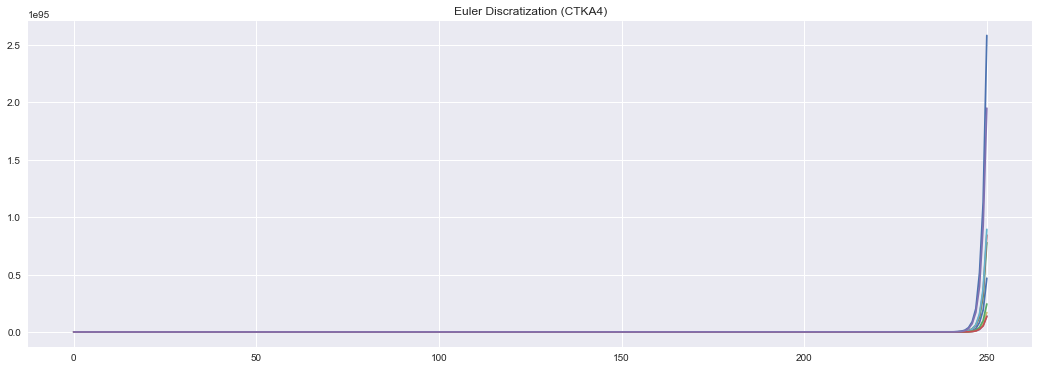

Resultado 83855313701203496289430031520509623686326367401749723031970271001203573052900092181305595265024.00000


In [72]:
log_returns = np.log(1 + analise['Adj Close'].pct_change())
r = 0.025
stdev = log_returns.std() * (250 ** 0.5)
stdev = np.array([stdev])
T = 1.0
t_intervals = 250

delta_t = T / t_intervals
iterations = 10000
z = np.random.standard_normal((t_intervals + 1, iterations))
s = np.zeros_like(z)
S0 = analise['Adj Close'].iloc[-1]

s[0] = S0


for t in range(1, t_intervals + 1):
    s[t] = s[t - 1] * np.exp((r - 0.5 * stdev ** 2) * delta_t + stdev + delta_t ** 0.5 * z[t])
    pass

p = np.maximum(s[-1] - 110, 0)
c = (np.exp(-r * T) * np.sum(p)) / iterations

plt.figure(figsize=(18,6))
plt.title(f'Euler Discratization ({ticker})')
plt.plot(s[ : , :10])


plt.show()

print(f'Resultado {c:0.5f}')

### Analise Fundamentalista
http://www.fundamentus.com.br/detalhes.php?papel=

In [73]:
dia = f'{datetime.datetime.now().year}-{datetime.datetime.now().month}-{datetime.datetime.now().day}'

Preco = analise['Adj Close'][-1]

if selenium is True:
    try:
        driver = webdriver.Chrome('A:/chromedriver.exe')
        selenium = True
        pass
    except:
        selenium = False
        pass
    pass

if selenium is True:
    
    driver.get(fundSite + ticker)

    NroAcoes = driver.find_element_by_xpath(xpath_numero_acoes).text
    NroAcoes = float(NroAcoes.replace('.', ''))

    VPatriLiq = driver.find_element_by_xpath(xpath_patrimonio_liquido).text
    VPatriLiq = float(VPatriLiq.replace('.', ''))

    LPA = driver.find_element_by_xpath(xpath_lpa).text
    LPA = float(LPA.replace(',', '.'))

    VPA = driver.find_element_by_xpath(xpath_vpa).text
    VPA = float(VPA.replace(',', '.'))

    driver.quit()
else:
    vals_1 = ['1.087.240.000', '10.143.400.000', '0,47', '9,33']
    vals_2 = []

    for v in vals_1:
        x = v.replace('.', '_')
        x = x.replace(',', '.')
        vals_2.append(float(x))

    NroAcoes = vals_2[0]
    VPatriLiq = vals_2[1]
    V_VP = Preco / (VPatriLiq / NroAcoes)
    LPA = vals_2[2]
    VPA = vals_2[3]


V_VP = Preco / (VPatriLiq / NroAcoes)
VIntrinseco = (22.5 * LPA * VPA) ** 0.5
JustoSimNao = (VIntrinseco - Preco) - 1
if JustoSimNao > 0:
    JustoSimNao = 'Sim'
else:
    JustoSimNao = 'Não'

FundReport = pd.DataFrame(
    [
        [
        ticker,
        Preco,
        round(V_VP, 5),
        VIntrinseco,
        JustoSimNao,
        LPA,
        VPA,
        VPatriLiq,
        NroAcoes,
        ]

        ],
    columns=[
        'Ticker',
        'Preco',
        'V/VP',
        'Valor Intrinseco',
        'Preço Justo',
        'LPA',
        'VPA',
        'Valor Patrimonial',
        'Numero Acoes',
        ],
    index=[dia]
    )


FundReport

,Ticker,Preco,V/VP,Valor Intrinseco,Preço Justo,LPA,VPA,Valor Patrimonial,Numero Acoes
2019-11-22,CTKA4,12.0,-0.22198,125.651196,Sim,-12.98,-54.06,-335439000.0,6205000.0


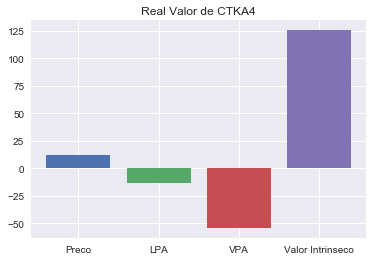

In [74]:
plt.bar('Preco', FundReport['Preco'], label='Preco')
plt.bar('LPA', FundReport['LPA'], label='Lucro Por Ação')
plt.bar('VPA', FundReport['VPA'], label='Valor Por Ação')
plt.bar('Valor Intrinseco', FundReport['Valor Intrinseco'], label='Valor Intrinseco')

plt.title(f'Real Valor de {ticker}')

#plt.legend()

plt.show()

In [75]:
print(f'Preço de Compra : {Preco * 100:.2f}\nLucro no Alvo : {(VIntrinseco - Preco) * 100:.2f}')

Preço de Compra : 1200.00
Lucro no Alvo : 11365.12
